In [1]:
import json
import numpy as np
from pp_utils import TimeStepStats, LinearSolveStats
from matplotlib import pyplot as plt
from typing import Sequence
# from plot_utils import *


with open("../stats/fpm_1_sticking.json", "r") as f:
    contents = json.load(f)

data = [TimeStepStats.from_json(x) for x in contents]


def get_gmres_iterations(x: Sequence[TimeStepStats]) -> list[float]:
    result = []
    for ts in x:
        for ls in ts.linear_solves:
            result.append(ls.gmres_iters)
    return result


def get_petsc_converged_reason(x: Sequence[TimeStepStats]) -> list[int]:
    result = []
    for ts in x:
        for ls in ts.linear_solves:
            result.append(ls.petsc_converged_reason)
    return result


def get_num_sticking_sliding_open(
    x: Sequence[TimeStepStats],
) -> tuple[list[int], list[int], list[int]]:
    sticking = []
    sliding = []
    open_ = []
    for ts in x:
        for ls in ts.linear_solves:
            st, sl, op = ls.num_sticking_sliding_open
            sticking.append(st)
            sliding.append(sl)
            open_.append(op)
    return sticking, sliding, open_


def group_intervals(arr):
    diffs = np.diff(arr)
    change_positions = np.where(diffs != 0)[0] + 1
    intervals = np.concatenate(([0], change_positions, [len(arr)]))
    return intervals

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Text(0.5, 0, '# matrix')

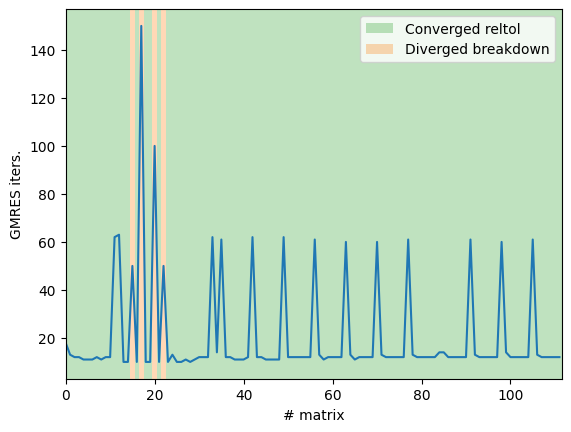

In [3]:
# %matplotlib ipympl

color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


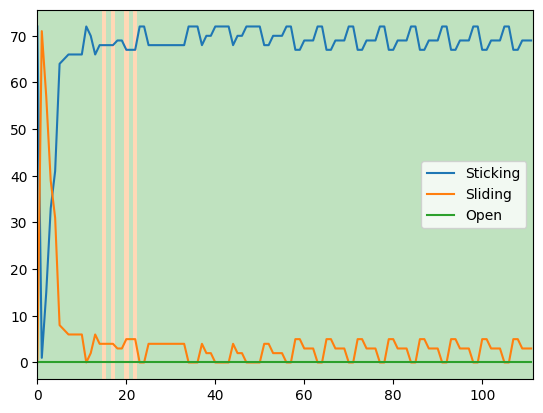

In [4]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
color_converged_reason(data, legend=False)
plt.plot(sticking, label='Sticking')
plt.plot(sliding, label='Sliding')
plt.plot(open_, label='Open')
plt.legend()

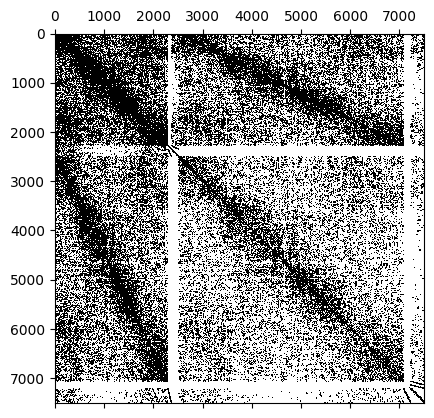

In [5]:
import scipy.sparse
from pathlib import Path
from plot_utils import *


def load_matrix(data: Sequence[TimeStepStats], idx: int):
    flat_data: list[LinearSolveStats] = [y for x in data for y in x.linear_solves]
    return scipy.sparse.load_npz(Path('../matrices') / flat_data[idx].matrix_id)

mat = load_matrix(data, 100)
spy(mat)

In [7]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_1 import make_model

model = make_model()
model.prepare_simulation()

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model.assemble_linear_system()

model._initialize_solver()
block_matrix = make_block_mat(model, mat)
eq_blocks = model.make_equations_indices()
var_blocks = model.make_variables_indices()

rhs = np.ones(mat.shape[0])

model.linear_system = mat, rhs

reordered_mat, preconditioner = model._prepare_solver()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Solve  took: 2.06
PETSc Converged Reason: -5


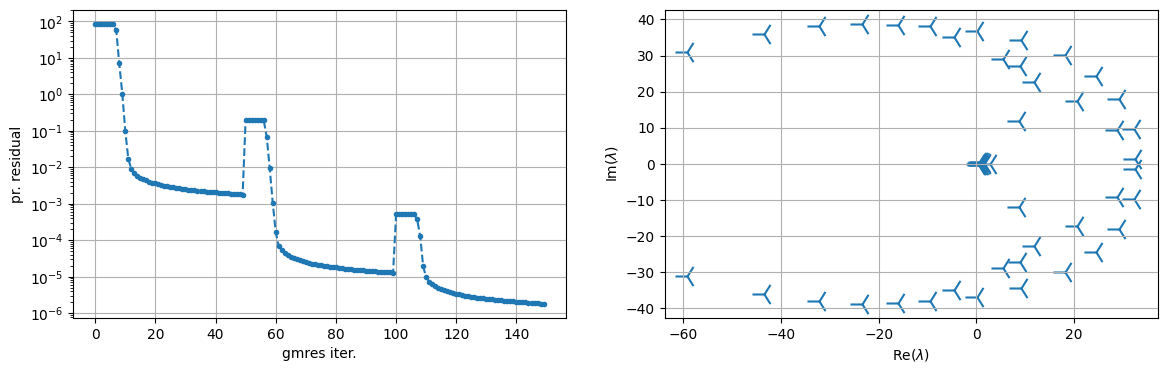

In [49]:
solve_petsc(reordered_mat, preconditioner, logx_eigs=False, normalize_residual=False)

In [22]:
cond(preconditioner.F_inv)

5.897008349620597e+27

Solve  took: 1.05


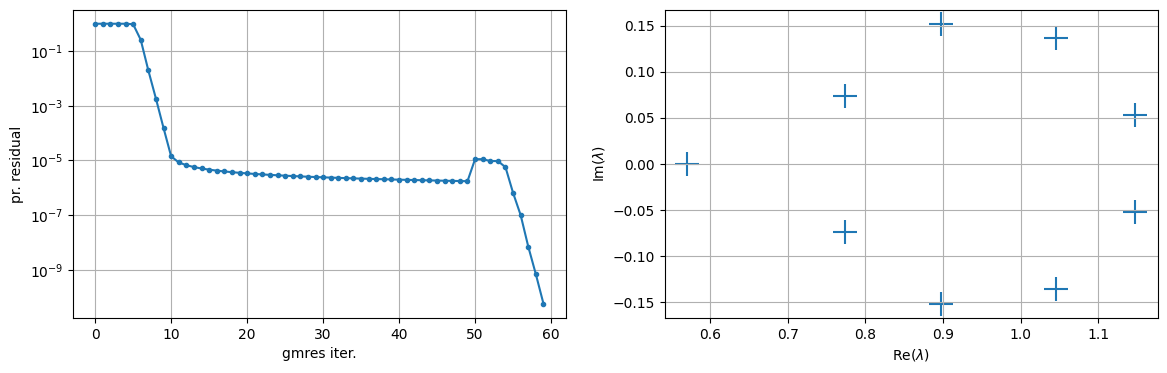

In [23]:
Omega_inv = preconditioner.Omega_inv
Omega = bmat([
    [model.Bp, model.C2p],
    [model.C1p, model.Ap]
])
solve_petsc(Omega, Omega_inv, logx_eigs=False)

Solve  took: 0.12


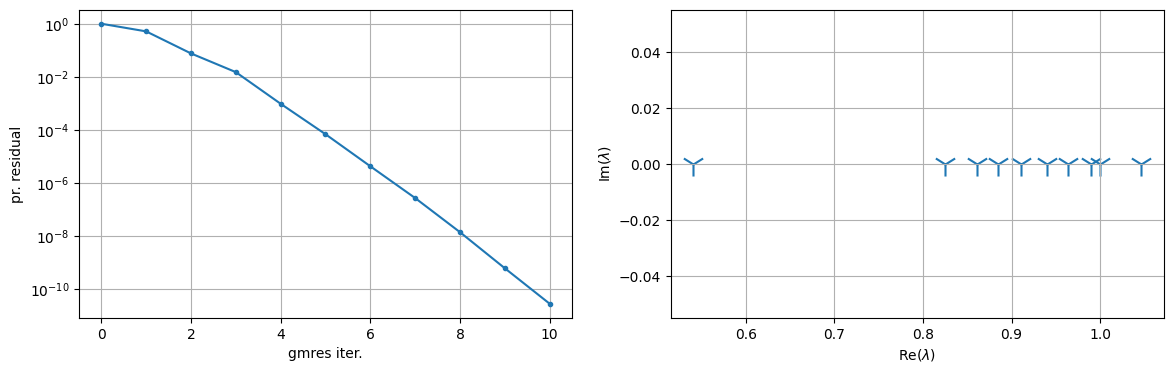

In [24]:
B_amg = Omega_inv.B_inv
B = B_amg.get_matrix()
solve_petsc(B, B_amg)

Solve  took: 0.01


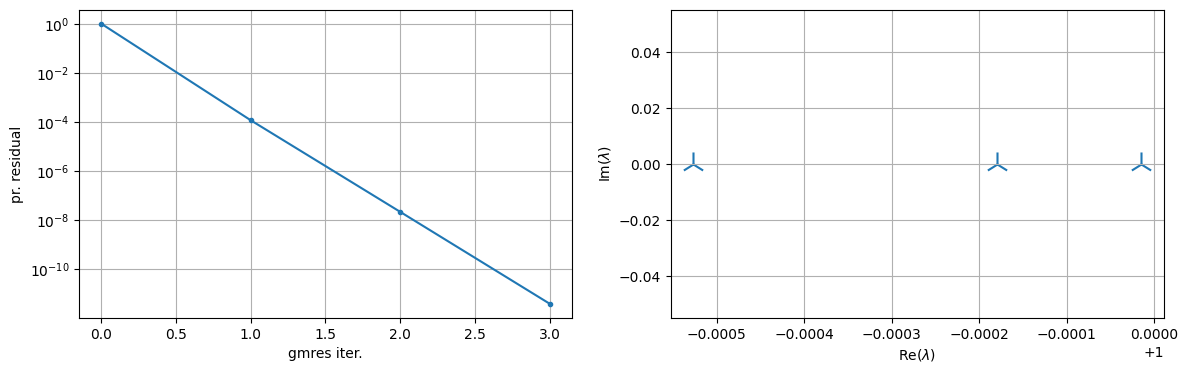

In [25]:
S_A_amg = Omega_inv.S_A_inv
S_A = S_A_amg.get_matrix()
solve_petsc(S_A, S_A_amg)

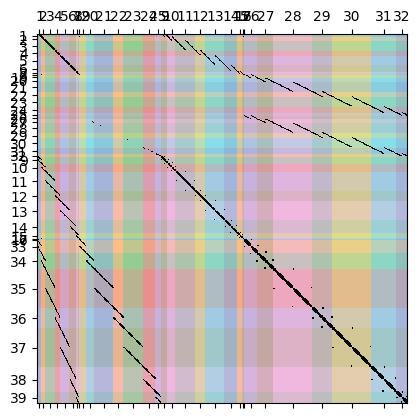

In [26]:
dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.contact_traction(sd_frac)],
        [model.interface_darcy_flux(intf)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_indices(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 3
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_darcy_flux_equation", intf)],  # 4
        [("interface_force_balance_equation", intf)],  # 5
    ],
)

# diagnostics = model.run_diagnostics(grouping='dense')
# model.plot_diagnostics(diagnostics, key='max')
# plot_mat(concatenate_blocks(block_matrix, eq_idx[3], var_idx[3]))
color_spy(
    block_matrix,
    eq_idx[2] + eq_idx[3] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[3] + var_idx[4] + var_idx[5],
); plt.show()
x = concatenate_blocks(
    block_matrix,
    eq_idx[2] + eq_idx[3] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[3] + var_idx[4] + var_idx[5],
)

In [27]:
cond(x)

1.272801053001294e+26

In [28]:
def get_F(data, idx):
    mat = load_matrix(data, idx)
    rhs = np.ones(mat.shape[0])
    model.linear_system = mat, rhs
    reordered_mat, preconditioner = model._prepare_solver()
    return model.F

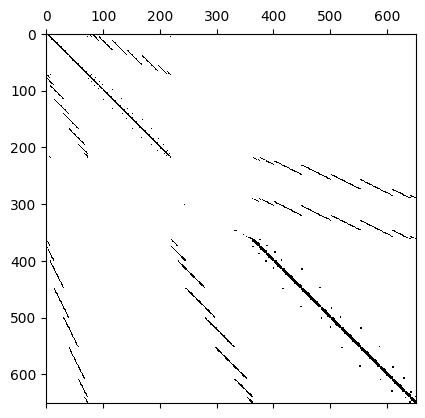

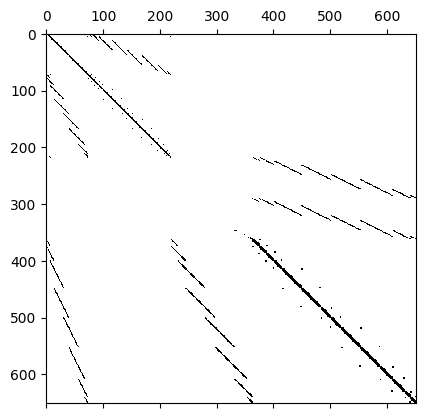

In [36]:
F15 = get_F(data, 15)
spy(F15); plt.show()
F16 = get_F(data, 16)
spy(F16); plt.show()

Solve F15 took: 0.0
PETSc Converged Reason: -5
Solve F16 took: 0.0
PETSc Converged Reason: -5


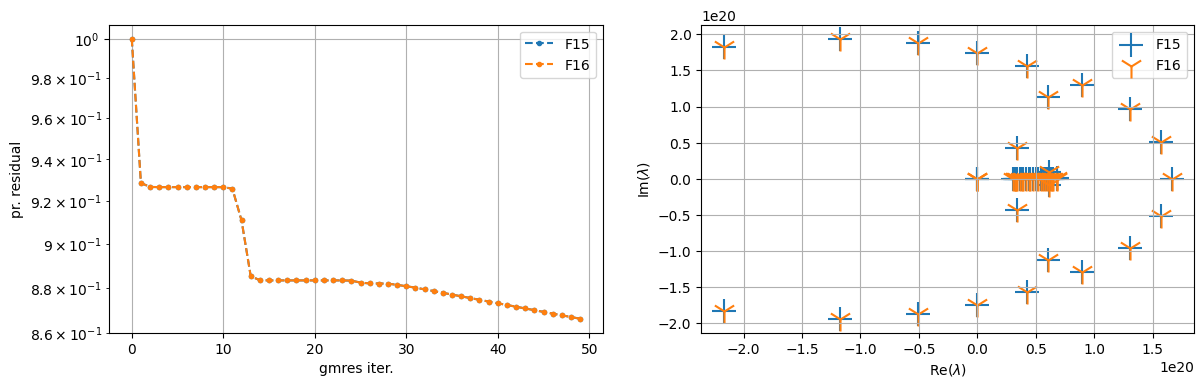

In [37]:
from scipy.sparse.linalg import inv
solve_petsc(F15, label='F15')
solve_petsc(F16, label='F16')

In [38]:
cond(F15 @ inv(F15))

1.0001546644153936

In [39]:
cond(F16 @ inv(F16))

1.000217902213849